## Enter the path of the folder of interest below as a string. Currently, the path points to the flowers dataset. 

In [0]:
# If required, change the below variable to point to the folder where the dataset is present (as a string)
data_path = 'flower_photos'

## Downloading the flowers dataset and unzipping them

In [34]:
!curl -O http://download.tensorflow.org/example_images/flower_photos.tgz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  218M  100  218M    0     0   126M      0  0:00:01  0:00:01 --:--:--  126M


In [0]:
!tar -xvf flower_photos.tgz > /dev/null

## Importing modules

In [0]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt 
import math
from sklearn.model_selection import train_test_split
import shutil
import numpy as np

## Class for the data preparation for Auto-ML

In [0]:
class auto_dl_data_prep:
  
  def __init__(self, data_full_path, test_ratio, validation_ratio):
    self.data_full_path = data_full_path
    self.class_counts = self.get_class_counts()
    self.classes = list(self.class_counts.keys())
    self.test_ratio = test_ratio
    self.validation_ratio = validation_ratio
    self.train_test_split()

  def get_class_counts(self):
    class_counts = {}
    for folder in os.listdir(self.data_full_path):
      if os.path.isdir(os.path.join(self.data_full_path, folder)):
        class_counts[folder] = len(os.listdir(os.path.join(self.data_full_path, folder)))
    return class_counts
  
  
  def class_metrics(self, test_ratio, validation_ratio):
    class_counts = self.get_class_counts()
    min_class_count = min(class_counts.values())
    test_count = math.floor(min_class_count * test_ratio)
    validation_count = math.floor(min_class_count * (1-test_ratio) * validation_ratio)
    train_count = math.floor(min_class_count * (1-test_ratio) * (1-validation_ratio))
    return (train_count, validation_count, test_count)
  
  
  def train_test_split(self):
    make_folders = [os.mkdir(x) for x in ['train', 'validation', 'test'] if not os.path.exists(x)]
    train_count, validation_count, test_count = self.class_metrics(test_ratio=self.test_ratio, validation_ratio=self.validation_ratio)
    
    for folder in os.listdir(self.data_full_path):
      if os.path.isdir(os.path.join(self.data_full_path, folder)):
        filelist = os.listdir(os.path.join(self.data_full_path, folder))
        
        X_train, X_test = train_test_split(filelist, train_size=train_count+validation_count, test_size=test_count)
        X_train, X_val = train_test_split(X_train, train_size=train_count, test_size=validation_count)

        for split in [('train', X_train), ('validation', X_val), ('test', X_test)]:
          if not os.path.exists(os.path.join(split[0], folder)):
            os.mkdir(os.path.join(split[0], folder))

          for imagefile in split[1]:
            shutil.copy(os.path.join(self.data_full_path, folder, imagefile), os.path.join(split[0], folder, imagefile))

## Instantiating the class with the path of the data folder and the test and validation split ratios

In [0]:
flowers_data = auto_dl_data_prep(data_full_path = data_path, test_ratio=0.2, validation_ratio=0.2)

## Using the VGG16 pretrained convnet with imagenet weights

In [0]:
conv_base = tf.keras.applications.VGG16(weights='imagenet', 
                                        include_top=False,
                                       input_shape=(150,150,3))                 

## Adding Dense Layers

In [0]:
model_conv_base = tf.keras.Sequential([
    conv_base,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(flowers_data.classes), activation='softmax')
])

## Freezing the conv base

In [0]:
conv_base.trainable=False

## Using the ImageDataGenerator class from TF Keras

In [0]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

## Setting up flow from the train and validation directories

In [181]:
train_generator = train_datagen.flow_from_directory(
        'train',
        target_size=(150, 150),
        batch_size=20,
        class_mode='sparse')

validation_generator = validation_datagen.flow_from_directory(
        'validation',
        target_size=(150, 150),
        batch_size=20,
        class_mode='sparse')

Found 2025 images belonging to 5 classes.
Found 505 images belonging to 5 classes.


## Compiling the model using adam

In [0]:
model_conv_base.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## Fitting the model

In [183]:
model_conv_base_history = model_conv_base.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/30
 - 44s - loss: 1.2832 - acc: 0.5075 - val_loss: 0.8567 - val_acc: 0.6934
Epoch 2/30
 - 43s - loss: 0.9783 - acc: 0.6330 - val_loss: 0.7225 - val_acc: 0.7503
Epoch 3/30
 - 41s - loss: 0.8567 - acc: 0.6690 - val_loss: 0.6434 - val_acc: 0.7797
Epoch 4/30
 - 42s - loss: 0.8140 - acc: 0.6820 - val_loss: 0.6365 - val_acc: 0.7797
Epoch 5/30
 - 43s - loss: 0.7890 - acc: 0.6925 - val_loss: 0.6508 - val_acc: 0.7614
Epoch 6/30
 - 43s - loss: 0.7634 - acc: 0.7055 - val_loss: 0.6247 - val_acc: 0.7665
Epoch 7/30
 - 42s - loss: 0.7088 - acc: 0.7355 - val_loss: 0.6341 - val_acc: 0.7929
Epoch 8/30
 - 42s - loss: 0.7296 - acc: 0.7295 - val_loss: 0.6106 - val_acc: 0.7706
Epoch 9/30
 - 41s - loss: 0.7177 - acc: 0.7315 - val_loss: 0.6064 - val_acc: 0.7777
Epoch 10/30
 - 41s - loss: 0.7100 - acc: 0.7415 - val_loss: 0.6087 - val_acc: 0.7746
Epoch 11/30
 - 42s - loss: 0.6398 - acc: 0.7625 - val_loss: 0.5995 - val_acc: 0.7787
Epoch 12/30
 - 41s - loss: 0.6819 - acc: 0.7565 - val_loss: 0.5631 - val_a

## Function to plot model history

In [0]:
def plot_history(histories, key='loss'):
    
    """
    Not sure if this works when epoch=1 but works when epoch is higher than 1
    """
    plt.figure(figsize=(20,10))
    for name, model_history in histories:
      train = plt.plot([x+1 for x in model_history.epoch], model_history.history[key],
                         label='Train '+ name)
      plt.plot([x+1 for x in model_history.epoch], model_history.history['val_'+ key], '--', color=train[0].get_color(),
                   label='Val ' + name)

    plt.xlabel('Epochs', fontsize=12)
    plt.xticks([x+1 for x in model_history.epoch])
    plt.ylabel(key.replace('_',' '), fontsize=12)
    plt.legend(loc=1, prop={'size': 12})
    plt.title('Plot of {} at different Epochs'.format(key), fontsize=18)

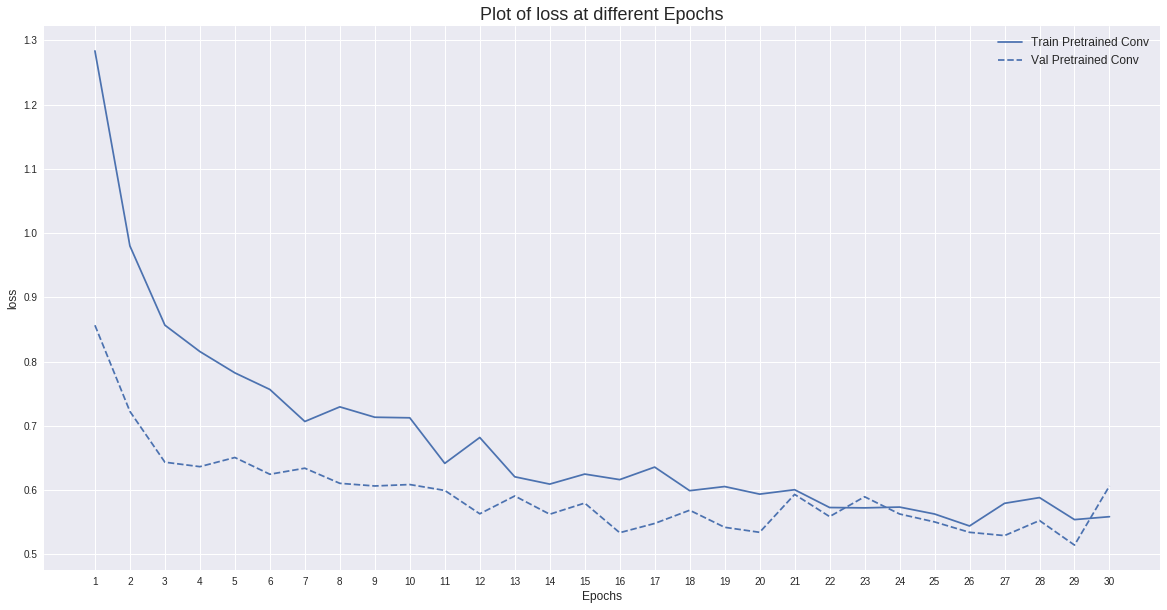

In [185]:
plot_history([('Pretrained Conv', model_conv_base_history)],  key='loss')

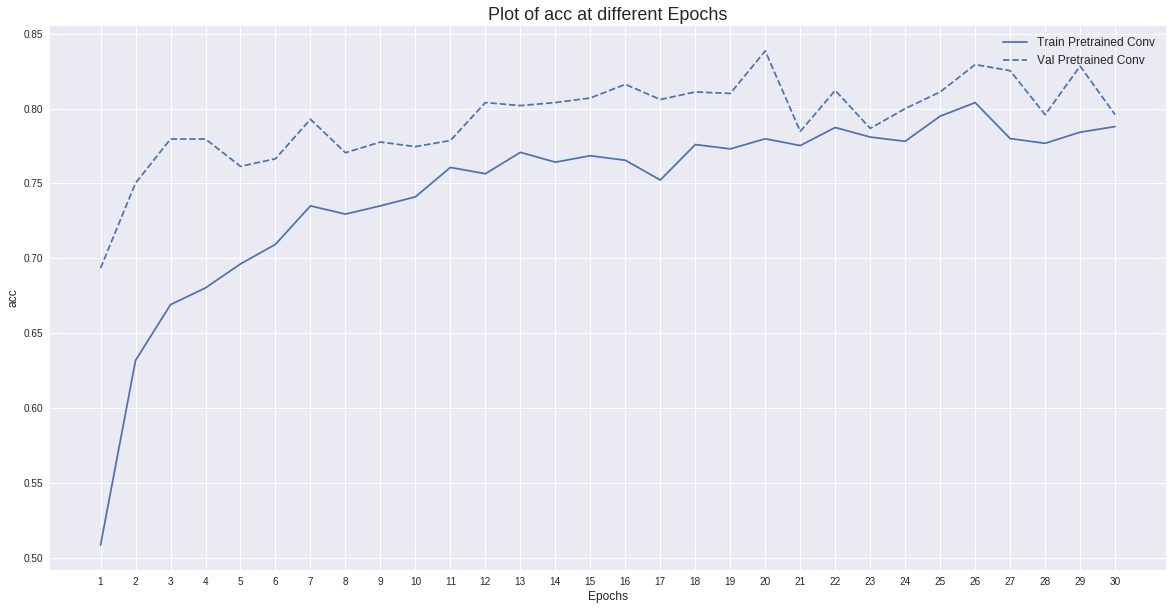

In [186]:
plot_history([('Pretrained Conv', model_conv_base_history)],  key='acc')

## Evaluate the test data with the pretrained conv model

In [187]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        'test',
        target_size=(150, 150),
        batch_size=20,
        class_mode='sparse')

test_loss, test_acc = model_conv_base.evaluate_generator(test_generator, steps=50)
print('Test loss:{0:.3f}'.format(test_loss))
print('Test accuracy:{0:.3f}'.format(test_acc))

Found 630 images belonging to 5 classes.
Test loss:0.593
Test accuracy:0.812


## Fine Tuning the conv net to check if we get better performance

In [188]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

## Unfreezing the last 3 convolutional layers

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name in ['block5_conv1','block5_conv2', 'block5_conv3']:
    layer.trainable = True
  else:
    layer.trainable = False

## Using a small learning rate for the model

In [0]:
model_conv_base.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])

In [191]:
model_conv_base_tuning_history = model_conv_base.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/30
 - 43s - loss: 0.5123 - acc: 0.8115 - val_loss: 0.5399 - val_acc: 0.8335
Epoch 2/30
 - 43s - loss: 0.4556 - acc: 0.8295 - val_loss: 0.5338 - val_acc: 0.8254
Epoch 3/30
 - 44s - loss: 0.4041 - acc: 0.8475 - val_loss: 0.5108 - val_acc: 0.8386
Epoch 4/30
 - 43s - loss: 0.3933 - acc: 0.8565 - val_loss: 0.5371 - val_acc: 0.8254
Epoch 5/30
 - 43s - loss: 0.3652 - acc: 0.8705 - val_loss: 0.5212 - val_acc: 0.8467
Epoch 6/30
 - 44s - loss: 0.3510 - acc: 0.8770 - val_loss: 0.5711 - val_acc: 0.8355
Epoch 7/30
 - 42s - loss: 0.3740 - acc: 0.8595 - val_loss: 0.4911 - val_acc: 0.8447
Epoch 8/30
 - 43s - loss: 0.3276 - acc: 0.8810 - val_loss: 0.5405 - val_acc: 0.8325
Epoch 9/30
 - 43s - loss: 0.3186 - acc: 0.8825 - val_loss: 0.5543 - val_acc: 0.8345
Epoch 10/30
 - 42s - loss: 0.2922 - acc: 0.8930 - val_loss: 0.5306 - val_acc: 0.8447
Epoch 11/30
 - 42s - loss: 0.2820 - acc: 0.8930 - val_loss: 0.5511 - val_acc: 0.8447
Epoch 12/30
 - 42s - loss: 0.2773 - acc: 0.9020 - val_loss: 0.5654 - val_a

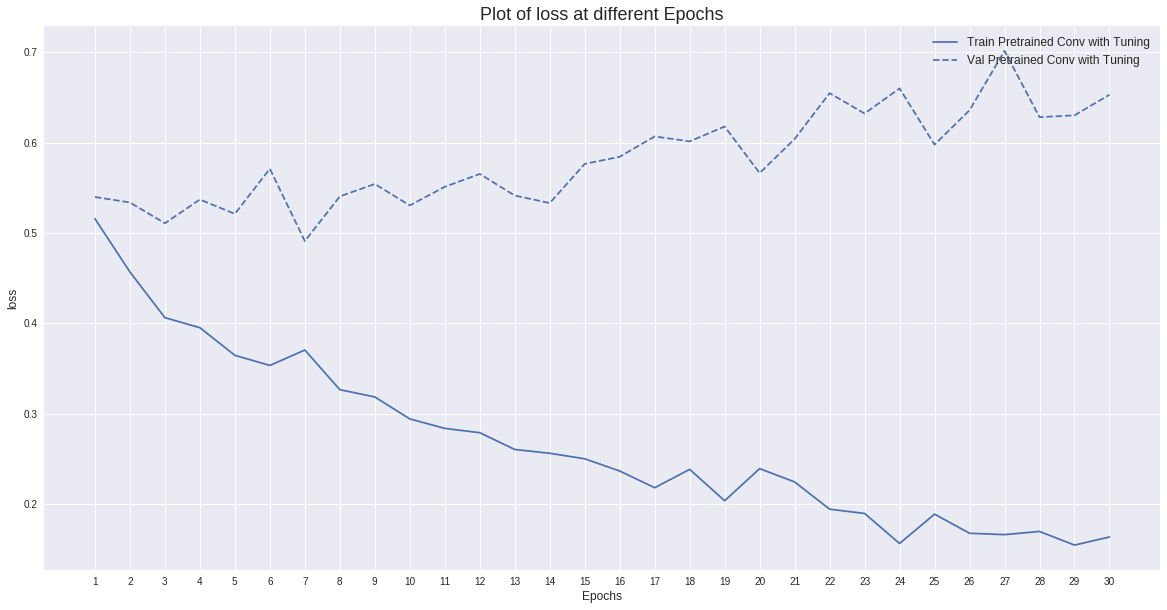

In [192]:
plot_history([('Pretrained Conv with Tuning', model_conv_base_tuning_history)],  key='loss')

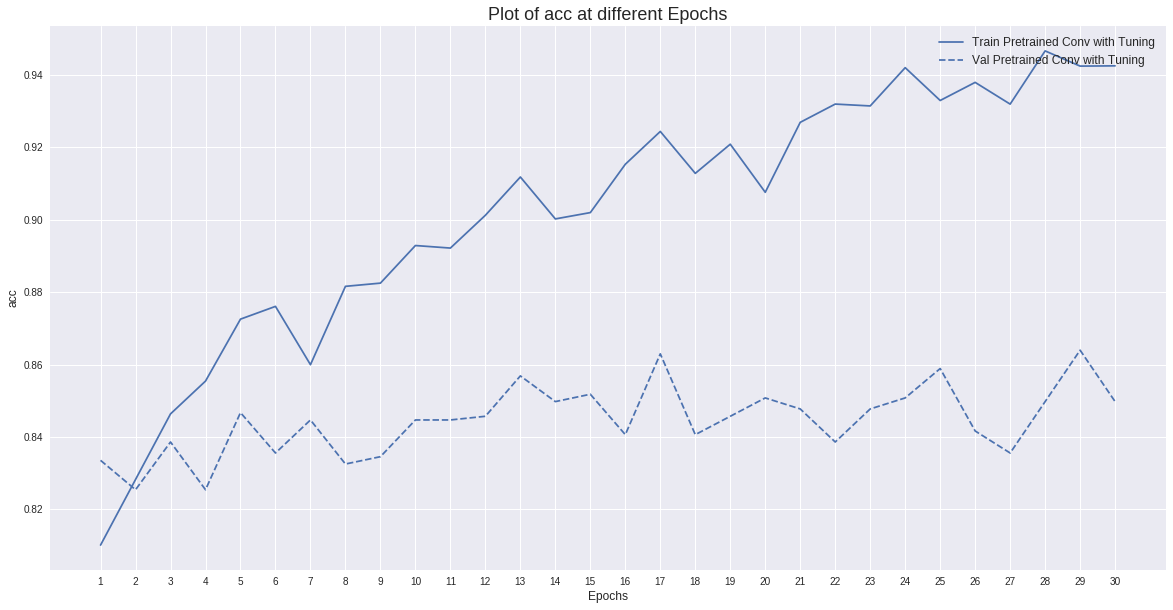

In [193]:
plot_history([('Pretrained Conv with Tuning', model_conv_base_tuning_history)],  key='acc')

## Evaluate the test data with the fine tuned model

In [194]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        'test',
        target_size=(150, 150),
        batch_size=20,
        class_mode='sparse')

test_loss, test_acc = model_conv_base.evaluate_generator(test_generator, steps=50)
print('Test loss:{0:.3f}'.format(test_loss))
print('Test accuracy:{0:.3f}'.format(test_acc))

Found 630 images belonging to 5 classes.
Test loss:0.549
Test accuracy:0.856


## Predicting the class for one sample image from each class from the test folder

In [0]:
# Getting the classes used by the image data generator
imagedatagen_classes = flowers_data.classes
imagedatagen_classes.sort()

### Predicts for a random image from the test dataset for each class

In [0]:
imagelist = []
for imageclass in imagedatagen_classes:
  imagelist.append(imageclass+'/'+np.random.choice(os.listdir('test/{}'.format(imageclass))))

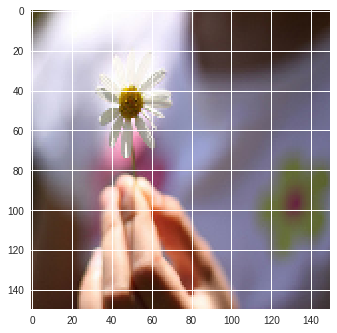

Classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
Prediction Probabilities: [[1. 0. 0. 0. 0.]]
Predicted Class: daisy


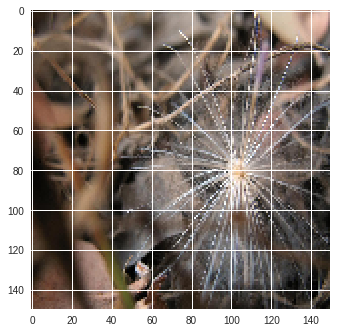

Classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
Prediction Probabilities: [[0. 1. 0. 0. 0.]]
Predicted Class: dandelion


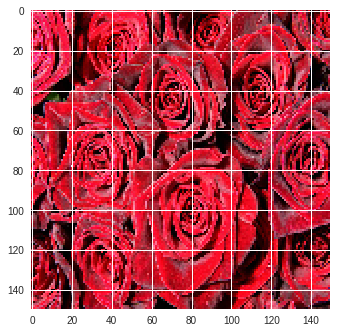

Classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
Prediction Probabilities: [[0. 0. 1. 0. 0.]]
Predicted Class: roses


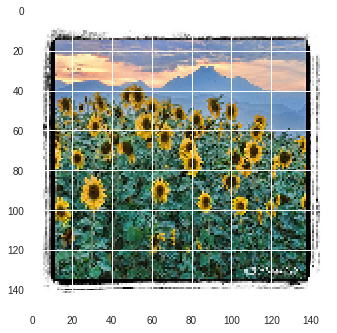

Classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
Prediction Probabilities: [[0. 0. 0. 1. 0.]]
Predicted Class: sunflowers


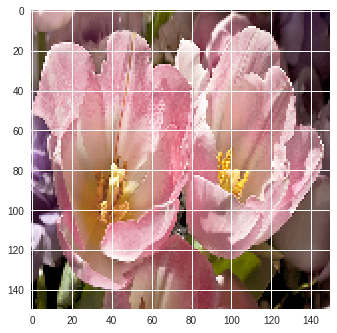

Classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
Prediction Probabilities: [[0. 0. 0. 0. 1.]]
Predicted Class: tulips


In [171]:
for imagepath in imagelist:
  img = tf.keras.preprocessing.image.load_img('test/{}'.format(imagepath), target_size=(150,150))
  plt.imshow(img)
  plt.show()
  img_array = np.asarray(img)
  pred = model_conv_base.predict(img_array.reshape(1,150,150,3))
  print ("Classes:", imagedatagen_classes)
  print ("Prediction Probabilities:", pred)
  print ("Predicted Class:", imagedatagen_classes[np.argmax(pred)])

## Summary
### Pretrained Convolutional Network
* The VGG 16 weights for imagenet were used
* The convolutional base was frozen for the initial model
* On the test dataset this model had a loss of **0.593** and an accuracy of **81.2%** (might be slightly different on reruns)

### Pretrained Convolutional Network with Fine Tuning
* The last three convolutional layers were fine tuned to get better performance
* On the test dataset this model had a loss of **0.549** and an accuracy of **85.6%** (might be slightly different on reruns)

### **We can see that fine tuning the last few layers helps improve the accuracy on the test dataset**